In [ ]:
import time
import sklearn
import numpy as np
import torch
# import deepxde as dde
import tqdm
import matplotlib.pyplot as plt
from model import MyDeepONet


"""
本模块用于求解以下反应-扩散偏微分方程（PDE）：

    u_t = u_xx + B(x) * u(x, t)

边界条件：

    u(0, t) = 0
    u(1, t) = U(t)

控制问题的解为：

    U(t) = ∫₀¹ k(1, y) * u(y, t) dy

通过以下变换：

    w(x, t) = u(x, t) - ∫₀ˣ k(x, y) * u(y, t) dy

PDE 可转化为：

    w_t = w_xx

边界条件：

    w(0, t) = 0
    w(1, t) = 0

其中，核函数 k(x, y) 满足以下 PDE：

    k_xx - k_yy = B(x) * k(x, y)

边界条件：

    k(x, 0) = 0
    k(x, x) = - ∫₀ˣ B(y)/2 dy
"""

def rdpde_solver(B: callable,
                 initial_condition: callable,
                 lower__boundary_condition: callable,
                 upper_boundary_condition: callable,
                 kernel: np.ndarray,
                 T: float,
                 N: int,
                 M: int) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    求解反应-扩散偏微分方程：
        u_t = u_xx + B(x)u
    边界条件：
        u(0, t) = 0
        u(1, t) = U(t)

    参数：
        B (callable): 函数 B(x)
        initial_condition (callable): 初始条件 u(x, 0)
        lower__boundary_condition (callable): 边界条件 u(0, t)
        upper_boundary_condition (callable): 边界条件 u(1, t)
        kernel (ndarray): 核函数 k(x, y)
        T (float): 终止时间
        N (int): x 方向的网格点数
        M (int): t 方向的网格点数

    返回：
        tuple: 包含以下内容的元组
            - u (ndarray): PDE 的解
            - x (ndarray): x 方向的网格点
            - t (ndarray): t 方向的网格点
    """
    # Step 1: Construct the grid points
    # x = [0, dx, 2dx, ..., 1-dx, 1] (N+1, 1)
    x = np.linspace(0, 1, N + 1)
    # t = [0, dt, 2dt, ..., T-dt, T] (M+1, 1)
    t = np.linspace(0, T, M + 1)
    dx = x[1] - x[0]
    dt = t[1] - t[0]
    r = dt/dx**2

    # 添加类型判断
    if callable(B):
        B_values = B(x)
    else:
        B_values = np.array(B)

    u = np.zeros((N + 1, M + 1))

    u[:, 0] = initial_condition(x)
    u[0, :] = lower__boundary_condition(t)
    for j in range(1, M + 1):
        # time marching
        for i in range(1, N):
            # spatial discretization
            u[i][j] = u[i][j - 1] + r * (u[i + 1][j - 1] - 2 * u[i][j - 1] + u[i - 1][j - 1]) + dt * B_values[i] * u[i][j - 1]
        # boundary condition
        u[0, j] = 0
        u[-1, j] = upper_boundary_condition(u[:, j], kernel, N, dx)
    return u, x, t


def initial_condition(x: np.ndarray) -> np.ndarray:
    """
    初始条件函数 u(x, 0) = 10

    参数：
        x (ndarray): x 方向的网格点

    返回：
        ndarray: 初始条件在网格点的值 u(x, 0)
    """
    return np.ones_like(x) * 10


def lower__boundary_condition(t: np.ndarray) -> np.ndarray:
    """
    边界条件函数 u(0, t) = 0

    参数：
        t (ndarray): t 方向的网格点

    返回：
        ndarray: 边界条件在网格点的值 u(0, t)
    """
    return np.zeros_like(t)


def upper_boundary_condition(u: np.ndarray, kernel: np.ndarray, N: int, dx: float) -> np.ndarray:
    """
    边界条件函数 u(1, t)，其中：
    u(1, t) = ∫₀¹ k(1, y) * u(y, t) dy

    核函数 k(x, y) 满足以下 PDE：
        k_xx - k_yy = B(x) * k
        k(x, 0) = 0
        k(x, x) = ∫₀ˣ B(y) dy

    参数：
        u (ndarray): PDE 的解 u(x, t)
        kernel (ndarray): 核函数 k(x, y)
        N (int): x 和 y 方向的网格点数
        dx (float): x 和 y 方向的网格步长

    返回：
        ndarray: 边界条件在网格点的值 u(1, t)
    """
    return sum(kernel[-1][0:N + 1]*u[0:N + 1])*dx


def openloop_boundary_condition(u: np.ndarray, kernel: np.ndarray, N: int, dx: float) -> np.ndarray:
    """
    开环控制条件 u(1, t) = 0

    参数：
        u (ndarray): PDE 的解 u(x, t)
        kernel (ndarray): 核函数 k(x, y)
        N (int): x 和 y 方向的网格点数
        dx (float): x 和 y 方向的网格步长

    返回：
        ndarray: 边界条件在网格点的值 u(1, t)
    """
    return np.zeros_like(u[-1])


def kernel_solver(B, N: int, L: int = 1) -> np.ndarray:
    """
    求解核函数 k(x, y) 满足的 PDE：
        k_xx - k_yy = B(x) * k
    边界条件：
        k(x, 0) = 0
        k(x, x) = - ∫₀ˣ B(y)/2 dy

    参数：
        B (callable 或 ndarray): 函数 B(x)，或在节点 x 上的数组形式的值。
        N (int): x 和 y 方向的网格点数
        L (int): x 和 y 方向的最大值，默认为 1

    返回：
        ndarray: 核函数在网格点的值 k(x, y)
    """
    x = np.linspace(0, L, N + 1)
    dx = x[1] - x[0]

    # 添加类型判断
    if callable(B):
        B_values = B(x)
    else:
        B_values = np.array(B)

    k = np.zeros((N + 1, N + 1))

    k[1, 1] = - (B_values[1] + B_values[0]) * dx / 4

    # Solve the PDE using finite difference method
    for i in range(1, N):
        # Boundary condition k(x, 0) = 0
        k[i + 1, 0] = 0
        # Boundary condition k(x, x) = - SUM_{0}^{x} B(y)/2*dy
        # k[i + 1, i + 1] = SUM_{0}^{i} {- (B[x[i + 1]]] + B[x[i]]])* 1/2 * dx/2}
        k[i + 1, i + 1] = k[i, i] - (B_values[i - 1] + B_values[i]) * dx / 4.0
        # k_x(x, x) = - B(x)/2
        # k_x(x, x) = (k[i + 1, i] - k[i, i]) / dx = - B[xi] / 2
        k[i + 1, i] = k[i, i] - dx * B_values[i] / 2
        for j in range(1, i):
            # k_xx = (k[i + 1, j] - 2 * k[i, j] + k[i - 1, j])/dx^2
            # k_yy = (k[i, j + 1] - 2 * k[i, j] + k[i, j - 1])/dy^2
            # k_xx - k_yy = B(x) * k   (dx = dy)
            # k[i + 1, j] + k[i - 1, j] - k[i, j + 1] - k[i, j - 1] = dx^2 * B(x[i]) * k[i, j]
            k[i + 1, j] = k[i, j + 1] + k[i, j - 1] - k[i - 1, j] + \
                (dx**2) * B_values[j] * (k[i, j + 1] + k[i, j - 1]) / 2

    return k


def get_l2_error(u: np.ndarray, u_hat: np.ndarray) -> float:
    """
    计算 L2 误差

    参数：
        u (ndarray): 真实解
        u_hat (ndarray): 预测解

    返回：
        float: L2 误差
    """
    return np.sqrt(np.mean((u - u_hat)**2, axis=0))


def generate_dataset(NB_func: int, Nx: int):
    amplitude = 50
    lamda = np.random.uniform(4, 9, NB_func)
    x = np.linspace(0, 1, Nx + 1)
    B_funcs = []
    k_funcs = []
    for i in range(NB_func):
        B_func = amplitude * np.sin(lamda[i] * np.arcsinh(x))
        B_funcs.append(B_func)
        k_funcs.append(kernel_solver(B_func, Nx))

    # 将B_funcs数组转换为堆叠形式

    data_x = []
    for i in range(NB_func):
        temp_x = []
        for j in range(Nx + 1):
            temp_x.append(B_funcs[i])
        data_x.append(temp_x)
    data_x = np.array(data_x, dtype=np.float32)
    data_y = np.array(k_funcs, dtype=np.float32)
    data_x = data_x.reshape(data_x.shape[0], -1)
    data_y = data_y.reshape(data_y.shape[0], -1)
    np.savetxt("data/rdpde/data_x.dat", data_x)
    np.savetxt("data/rdpde/data_y.dat", data_y)
    np.savetxt("data/rdpde/lamda.dat", lamda)


def get_dataset(batch_size: int, device: torch.device):
    # Load the dataset
    data_x = np.loadtxt("data/rdpde/data_x.dat", dtype=np.float32)
    data_y = np.loadtxt("data/rdpde/data_y.dat", dtype=np.float32)
    lamda = np.loadtxt("data/rdpde/lamda.dat", dtype=np.float32)
    
    # Split the dataset
    x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(
        data_x, data_y, test_size=0.2)

    # Convert the dataset to PyTorch tensors
    x_train = torch.from_numpy(x_train).cuda(device)
    x_test = torch.from_numpy(x_test).cuda(device)
    y_train = torch.from_numpy(y_train).cuda(device)
    y_test = torch.from_numpy(y_test).cuda(device)

    # Create the DataLoader
    trainData = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True, generator=torch.Generator(device))
    testData = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False, generator=torch.Generator(device))

    return trainData, testData, lamda


class BranchNet(torch.nn.Module):
    # def __init__(self, input_size):
    #     super().__init__()
    #     # input_size 应该等于 (Nx + 1) * (Nx + 1)，因为 data_x 在生成时被展平了
    #     self.fc1 = torch.nn.Linear(input_size, 128)
    #     self.relu = torch.nn.ReLU()
    #     self.fc2 = torch.nn.Linear(128, 256)
    #     self.fc3 = torch.nn.Linear(256, 256) # 确保输出维度与 trunk net 匹配

    # def forward(self, x):
    #     # 对于 FNN，输入 x 预期是平坦的特征向量
    #     # 原始代码中 data_x 在 load 时已被 reshape 成 (batch_size, (Nx+1)*(Nx+1))
    #     # 所以这里的 x 已经是正确形状，无需额外的 reshape
    #     x = self.fc1(x)
    #     x = self.relu(x)
    #     x = self.fc2(x)
    #     x = self.relu(x)
    #     x = self.fc3(x)
    #     return x
    
    def __init__(self, shape):
        super().__init__()
        self.shape = shape
        self.conv1 = torch.nn.Conv2d(1, 16, 5, stride=2)
        self.relu = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv2d(16,32, 5, stride=2)
        self.fc1 = torch.nn.Linear(73728, 1028)
        self.fc2 = torch.nn.Linear(1028, 256)
        
    def forward(self, x):
        x = torch.reshape(x, (x.shape[0], 1, self.shape, self.shape))
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

def setup_model(Nx: int, 
                dim_x: int, 
                learning_rate: float, 
                step_size: int,
                gamma: float,
                device: torch.device, 
                activation: str = "relu", 
                initializer: str = "Glorot normal"):
    m = (Nx + 1)**2
    # Branch = BranchNet(m) 
    Branch = BranchNet(Nx + 1)
    model = MyDeepONet(Branch, [dim_x, 128, 256, 256]).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    return model, optimizer, scheduler

def train(model: torch.nn.Module, 
          optimizer: torch.optim.Optimizer, 
          scheduler: torch.optim.lr_scheduler.StepLR, 
          trainData: torch.utils.data.DataLoader, 
          testData: torch.utils.data.DataLoader,
          grads: torch.Tensor,
          epochs: int, 
          device: torch.device):
    loss = torch.nn.MSELoss()
    train_loss_history = []
    test_loss_history = []
    time_history = []
    pbar = tqdm.tqdm(range(epochs), desc='description')  # 创建进度条

    for epoch in tqdm.tqdm(range(epochs)):
        start_time = time.time()
        model.train()
        train_loss = 0
        for x, y in trainData:
            x = x.cuda(device)
            y = y.cuda(device)
            optimizer.zero_grad()
            y_pred = model((x, grads))
            eq_loss = loss(y_pred, y)
            eq_loss.backward()
            optimizer.step()
            train_loss += eq_loss.item()
        
        train_loss /= len(trainData)
        train_loss_history.append(train_loss)
        scheduler.step()
        
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for x, y in testData:
                x = x.cuda(device)
                y = y.cuda(device)
                y_pred = model((x, grads))
                test_loss += loss(y_pred, y).item()
        test_loss /= len(testData)
        test_loss_history.append(test_loss)

        eq_time = time.time() - start_time
        time_history.append(eq_time)
        if epoch % 1 == 0:
            pbar.update(1)
            pbar.set_description("Train Loss: %.2e, Test Loss: %.2e" % (train_loss, test_loss))
    pbar.close()
    return model, train_loss_history, test_loss_history, time_history


Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Parameters
L = 1
T = 1.5
NB_func = 1000
dim_x = 2
Nx = 200
Nt = 150000
epochs = 500
batch_size = 20
learning_rate = 1e-3
step_size = 50
gamma = 0.5
# Generate the axis
spatial = np.linspace(0, 1, Nx + 1)
temporal = np.linspace(0, T, Nt + 1)
# Generate the grid
grids = []
grids.append(spatial)
grids.append(spatial)
grid = np.vstack([xx.ravel() for xx in np.meshgrid(*grids)]).T
grid = torch.from_numpy(grid.astype(np.float32)).cuda(device)


In [3]:

# Generate the dataset
generate_dataset(NB_func, Nx)


In [4]:
# Load the dataset
trainData, testData, lamda = get_dataset(batch_size, device)


In [5]:
# Setup the model
model, optimizer, scheduler = setup_model(Nx, dim_x, learning_rate, step_size, gamma, device)
print(model)

MyDeepONet(
  (branch_net): BranchNet(
    (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 2))
    (relu): ReLU()
    (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
    (fc1): Linear(in_features=73728, out_features=1028, bias=True)
    (fc2): Linear(in_features=1028, out_features=256, bias=True)
  )
  (trunk_net): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
  )
)


In [ ]:
# Train the model
model, train_loss_history, test_loss_history, time_history = train(model, optimizer, scheduler,trainData, testData, grid, epochs, device)


In [7]:
# Save the model
torch.save(model, "model/rdpde/model.pth")


In [8]:

model = torch.load("model/rdpde/model.pth")

/tmp/ipykernel_2875/3602131602.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("model/rdpde/model.pth")


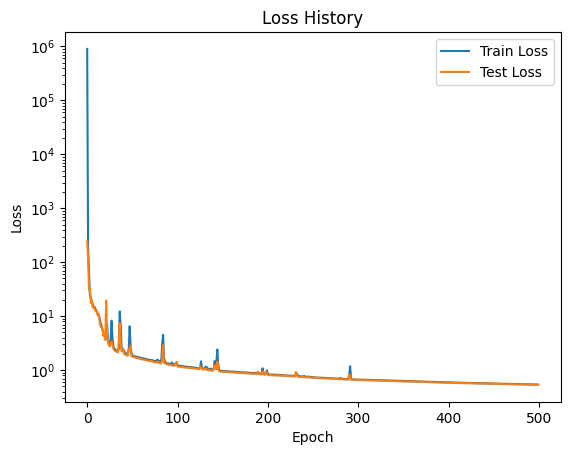

In [9]:
# Plot the loss history

fig = plt.figure()
plt.plot(train_loss_history, label="Train Loss")
plt.plot(test_loss_history, label="Test Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")
plt.title("Loss History")
plt.show()
fig.savefig("model/rdpde/loss_history.pdf")


In [10]:
# Evaluate the model
# setup the evaluation parameters
eval_lamda = [5, 8]
amplitude = 50
eval_u = []
eval_k = []
eval_u_hat = []
eval_k_hat = []
eval_u_openloop = []
eval_B_funcs = []
# Generate the evaluation data
for i in range(len(eval_lamda)):
    eval_B = amplitude * np.sin(eval_lamda[i] * np.arcsinh(spatial))
    k = kernel_solver(eval_B, Nx)
    eval_B_funcs.append(eval_B)
    x_eval = []
    for j in range(Nx + 1):
        x_eval.append(eval_B)
    x_eval = np.array(x_eval, dtype=np.float32)
    x_eval = x_eval.reshape(1, -1)
    x_eval = torch.from_numpy(x_eval).cuda(device)
    k_hat = model((x_eval, grid)).detach().cpu().numpy().reshape(Nx + 1, Nx + 1)
    u, x, t = rdpde_solver(eval_B, initial_condition, lower__boundary_condition,upper_boundary_condition, k, T, Nx, Nt)
    u_hat, x, t = rdpde_solver(eval_B, initial_condition, lower__boundary_condition,upper_boundary_condition, k_hat, T, Nx, Nt)
    u_openloop, x, t = rdpde_solver(eval_B, initial_condition, lower__boundary_condition,openloop_boundary_condition, k, T, Nx, Nt)
    eval_u.append(u)
    eval_k.append(k)
    eval_u_hat.append(u_hat)
    eval_k_hat.append(k_hat)
    eval_u_openloop.append(u_openloop)


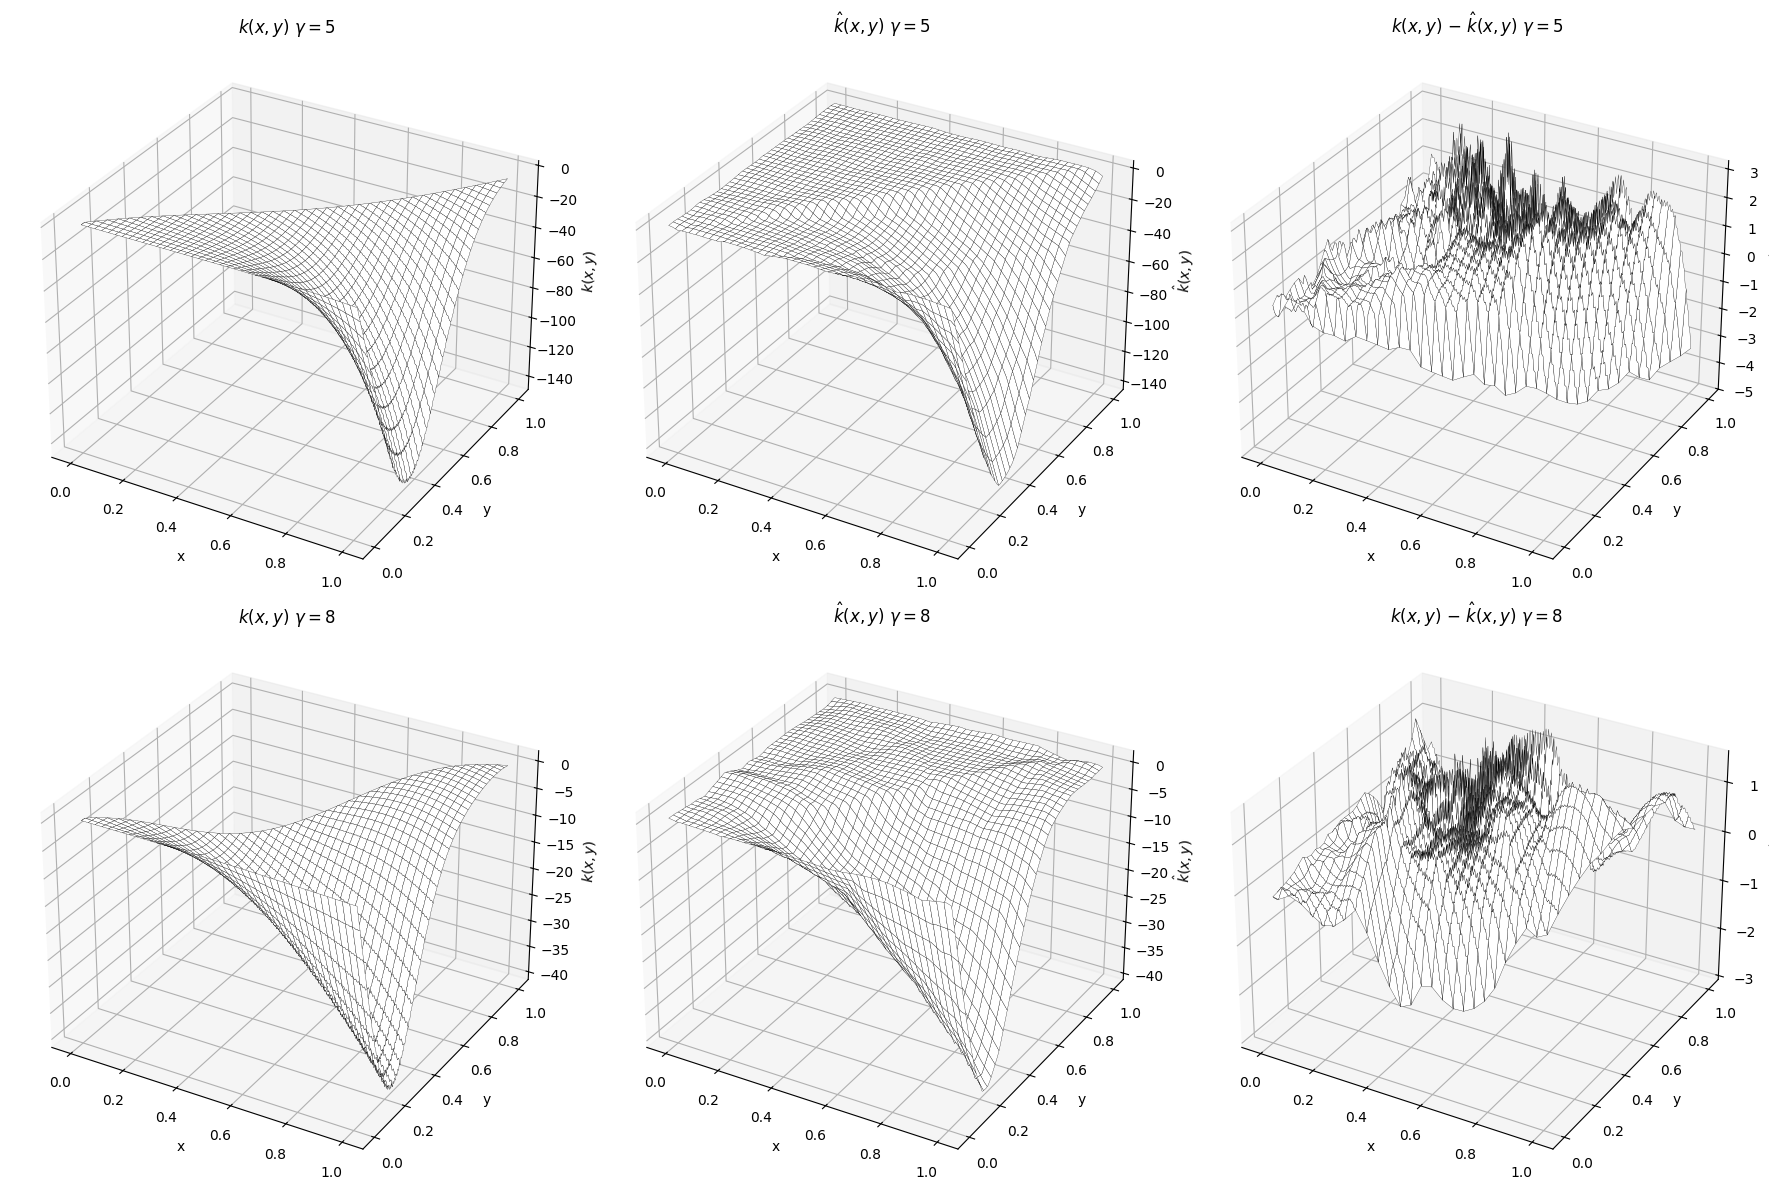

In [11]:
# Plot the evaluation results

def zero2nan(x):
    x[x == 0] = np.nan
    return x


fig = plt.figure(figsize=(18, 12), facecolor='white')
for i in range(len(eval_lamda)):
    ax1 = fig.add_subplot(2, 3, 3*i + 1, projection='3d')
    ax2 = fig.add_subplot(2, 3, 3*i + 2, projection='3d')
    ax3 = fig.add_subplot(2, 3, 3*i + 3, projection='3d')
    X, Y = np.meshgrid(spatial, spatial)
    ax1.plot_surface(X, Y, zero2nan(eval_k[i].T), edgecolor="black", lw=0.2, rstride=5, cstride=5, alpha=1, color="white", shade=False, rasterized=True)
    ax1.set_title(r'$k(x, y)$ $\gamma=%d$' % eval_lamda[i])
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    # ax1.invert_yaxis()
    ax1.set_zlabel(r'$k(x, y)$')
    ax2.plot_surface(X, Y, zero2nan(eval_k_hat[i].T), edgecolor="black", lw=0.2, rstride=5, cstride=5, alpha=1, color="white", shade=False, rasterized=True)
    ax2.set_title(r'$\hat k(x, y)$ $\gamma=%d$' % eval_lamda[i])
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    # ax2.invert_yaxis()
    ax2.set_zlabel(r'$\hat k(x, y)$')
    ax3.plot_surface(X, Y, eval_k[i] - eval_k_hat[i], edgecolor="black", lw=0.2, rstride=5, cstride=5, alpha=1, color="white", shade=False, rasterized=True)
    ax3.set_title(r'$k(x, y)$ $-$ $\hat k(x, y)$ $\gamma=%d$' % eval_lamda[i])
    ax3.set_xlabel('x')
    ax3.set_ylabel('y')
    # ax3.invert_yaxis()
    ax3.set_zlabel(r'$k(x, y)$ $-$ $\hat k(x, y)$')
plt.tight_layout()
plt.show()
fig.savefig("model/rdpde/kernel_evaluation.pdf", 
            format='pdf', 
            bbox_inches='tight', 
            pad_inches=0.5, 
            facecolor='w', 
            edgecolor='w')


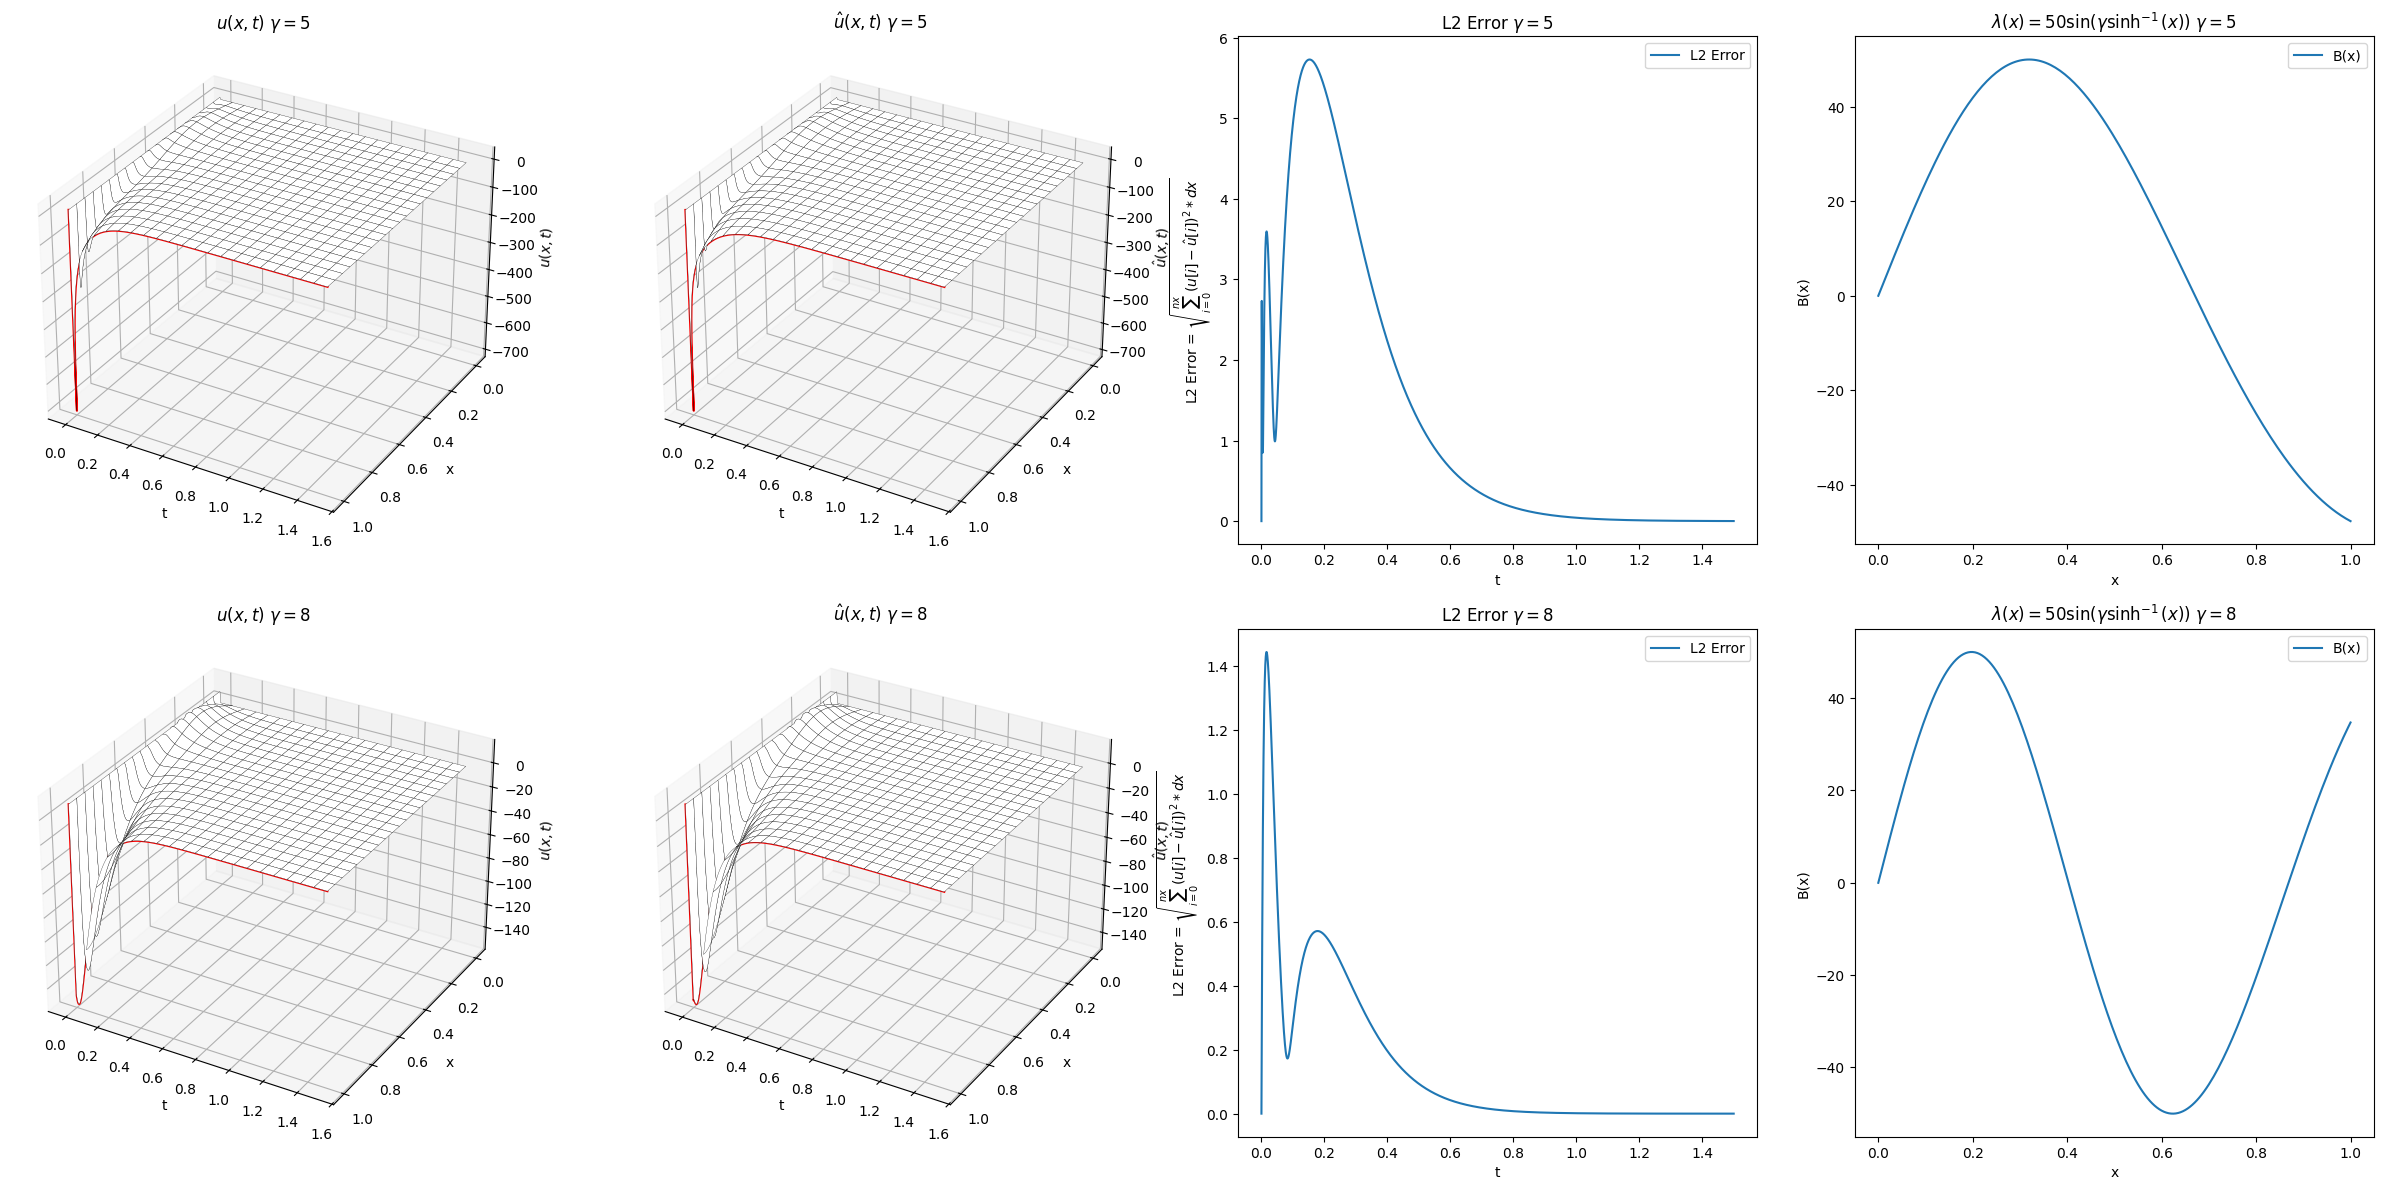

In [12]:
fig = plt.figure(figsize=(24, 12), facecolor='white')
for i in range(len(eval_lamda)):
    ax1 = fig.add_subplot(2, 4, 4*i + 1, projection='3d')
    ax2 = fig.add_subplot(2, 4, 4*i + 2, projection='3d')
    ax3 = fig.add_subplot(2, 4, 4*i + 3)
    ax4 = fig.add_subplot(2, 4, 4*i + 4)
    X, T = np.meshgrid(spatial, temporal)

    ax1.plot_surface(T, X, eval_u[i].T, edgecolor="black", lw=0.2, rstride=7500, cstride=10, alpha=1, color="white", shade=False, rasterized=True)
    ax1.plot(T[:, 0], np.ones_like(T[:, 0]), eval_u[i][-1, :], color='r', label='x=0')
    ax1.set_title(r'$u(x, t)$ $\gamma=%d$' % eval_lamda[i])
    ax1.set_xlabel('t')
    ax1.set_ylabel('x')
    ax1.invert_yaxis() 
    ax1.set_zlabel(r'$u(x, t)$')

    ax2.plot_surface(T, X, eval_u_hat[i].T, edgecolor="black", lw=0.2, rstride=7500, cstride=10, alpha=1, color="white", shade=False, rasterized=True)
    ax2.plot(T[:, 0], np.ones_like(T[:, 0]), eval_u_hat[i][-1, :], color='r', label='x=0')
    ax2.set_title(r'$\hat u(x, t)$ $\gamma=%d$' % eval_lamda[i])
    ax2.set_xlabel('t')
    ax2.set_ylabel('x')
    ax2.invert_yaxis() 
    ax2.set_zlabel(r'$\hat u(x, t)$')

    ax3.plot(temporal, get_l2_error(eval_u[i], eval_u_hat[i]), label='L2 Error')
    ax3.set_title(r'L2 Error $\gamma=%d$' % eval_lamda[i])
    ax3.set_xlabel('t')
    ax3.set_ylabel(r'L2 Error = $\sqrt{\sum_{i=0}^{nx} (u[i] - \hat{u}[i])^2*dx}$')
    ax3.legend()

    ax4.plot(spatial, eval_B_funcs[i], label='B(x)')
    title = r"$\lambda(x)=50\sin(\gamma \sinh^{-1}(x))$ $\gamma=%d$" % eval_lamda[i]
    ax4.set_title(title)
    ax4.set_xlabel('x')
    ax4.set_ylabel('B(x)')
    ax4.legend()
plt.tight_layout()
plt.show()
fig.savefig("model/rdpde/numerical_results.pdf", 
            format='pdf', 
            bbox_inches='tight', 
            pad_inches=0.5, 
            facecolor='w', 
            edgecolor='w')


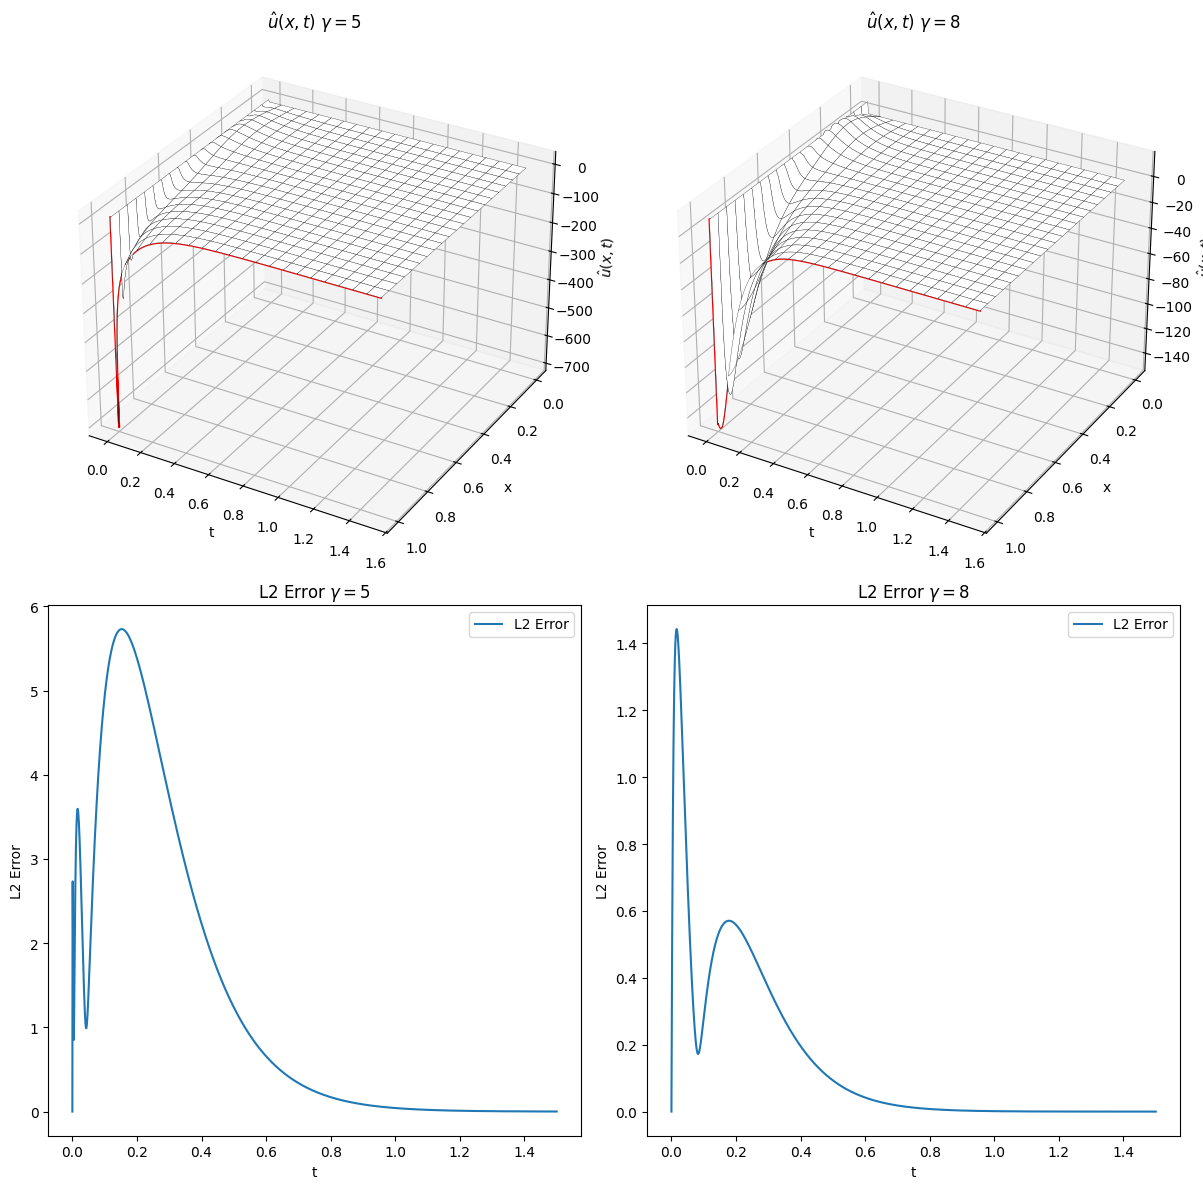

In [13]:
fig = plt.figure(figsize=(12, 12), facecolor='white')
for i in range(len(eval_lamda)):
    ax1 = fig.add_subplot(2, 2, i + 1, projection='3d')
    ax2 = fig.add_subplot(2, 2, i + 3)
    X, T = np.meshgrid(spatial, temporal)
    ax1.plot_surface(T, X, eval_u_hat[i].T, edgecolor="black", lw=0.2, rstride=7500, cstride=10, alpha=1, color="white", shade=False, rasterized=True)
    ax1.plot(T[:, 0], np.ones_like(T[:, 0]), eval_u_hat[i][-1, :], color='r', label='x=0')
    ax1.set_title(r'$\hat u(x, t)$ $\gamma=%d$' % eval_lamda[i])
    ax1.set_xlabel('t')
    ax1.set_ylabel('x')
    ax1.invert_yaxis() 
    ax1.set_zlabel(r'$\hat u(x, t)$')
    ax2.plot(temporal, get_l2_error(eval_u[i], eval_u_hat[i]), label='L2 Error')
    ax2.set_title(r'L2 Error $\gamma=%d$' % eval_lamda[i])
    ax2.set_xlabel('t')
    ax2.set_ylabel('L2 Error')
    ax2.legend()
plt.tight_layout()
plt.show()
fig.savefig("model/rdpde/solution_evaluation.pdf", 
            format='pdf', 
            bbox_inches='tight', 
            pad_inches=0.5, 
            facecolor='w', 
            edgecolor='w')

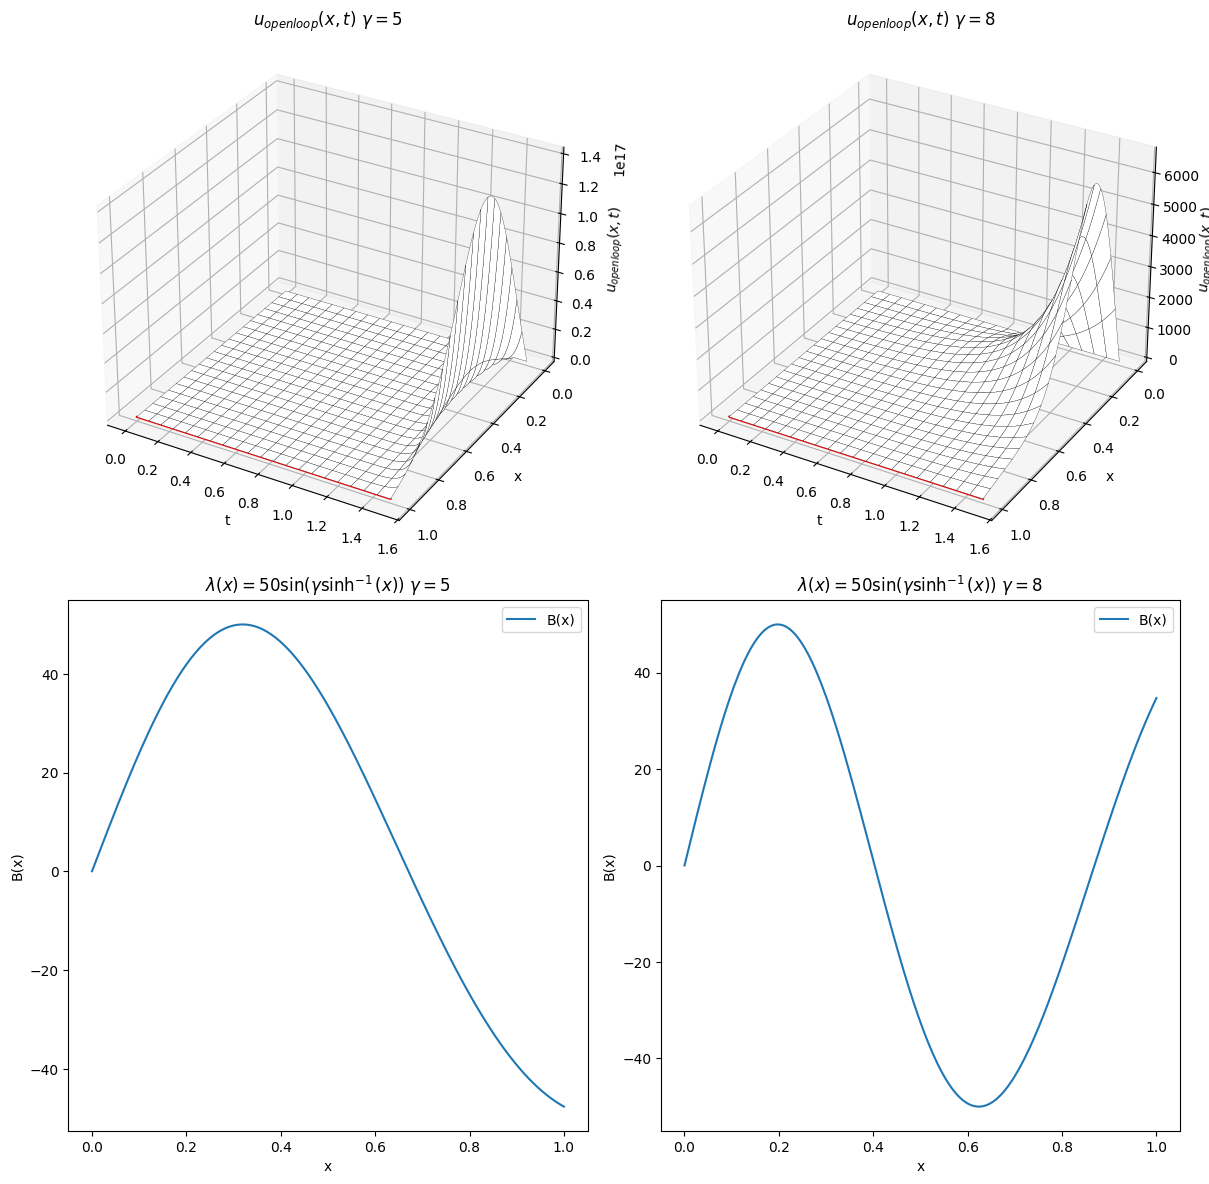

In [14]:
fig = plt.figure(figsize=(12, 12), facecolor='white')
for i in range(len(eval_lamda)):
    ax1 = fig.add_subplot(2, 2, i + 1, projection='3d')
    ax2 = fig.add_subplot(2, 2, i + 3)
    X, T = np.meshgrid(spatial, temporal)
    ax1.plot_surface(T, X, eval_u_openloop[i].T, edgecolor="black", lw=0.2, rstride=7500, cstride=10, alpha=1, color="white", shade=False, rasterized=True)
    ax1.plot(T[:, 0], np.ones_like(T[:, 0]), eval_u_openloop[i][-1, :], color='r', label='x=0')
    ax1.set_title(r'$u_{openloop}(x, t)$ $\gamma=%d$' % eval_lamda[i])   
    ax1.set_xlabel('t')
    ax1.set_ylabel('x')
    ax1.invert_yaxis() 
    ax1.set_zlabel(r'$u_{openloop}(x, t)$')
    ax2.plot(spatial, eval_B_funcs[i], label='B(x)')
    title = r"$\lambda(x)=50\sin(\gamma \sinh^{-1}(x))$ $\gamma=%d$" % eval_lamda[i]
    ax2.set_title(title)
    ax2.set_xlabel('x')
    ax2.set_ylabel('B(x)')
    ax2.legend()
plt.tight_layout()
plt.show()
fig.savefig("model/rdpde/openloop_evaluation.pdf", 
            format='pdf', 
            bbox_inches='tight', 
            pad_inches=0.5, 
            facecolor='w', 
            edgecolor='w')